In [27]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import contextlib

# 1. Preprocessing


In [28]:
ravdess_data = "data/RAVDESS/Speech/"

In [29]:
def extract_labels(file_name:str)->int:
    parts = file_name.split('-')
    emotion = int(parts[2])  # Emotion is the third part
    return emotion

def label_to_emotion(label:int)->str:
    if label == 1:
        return "neutral"
    elif label == 2:
        return "calm"
    elif label == 3:
        return "happy"
    elif label == 4:
        return "sad"
    elif label == 5:
        return "angry"
    elif label == 6:
        return "fearful"
    elif label == 7:
        return "disgust"
    elif label == 8:
        return "surprised"
    else:
        return "unknown"

def create_dataframe(directory:str)->pd.DataFrame:
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label = extract_labels(file)
                emotion = label_to_emotion(label)
                data.append({"FilePath": file_path, "Emotion": emotion, "Label": label})
    df = pd.DataFrame(data)
    return df

In [30]:
dataframe = create_dataframe(ravdess_data)

In [31]:
dataframe.head()

,FilePath,Emotion,Label
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7


In [32]:
print(dataframe.Emotion.value_counts())


Emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


# 2. Data Visualisation and Exploration

In [33]:
dataframe.count()

FilePath    1440
Emotion     1440
Label       1440
dtype: int64

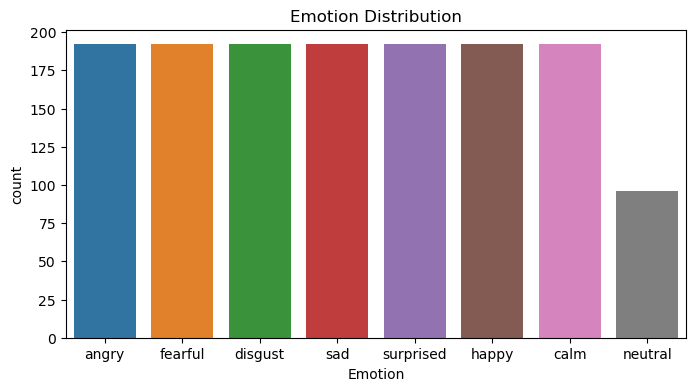

In [34]:
plt.figure(figsize=(8, 4))
sns.countplot(data=dataframe, x="Emotion")
plt.title("Emotion Distribution")
plt.show()

**Check the sampling rate of one random file to make sure it is the same as the one mentioned on the database website.**

In [35]:
sampling_rate = 0
with contextlib.closing(wave.open(dataframe.FilePath[6], 'r')) as wav_file:
    sampling_rate = wav_file.getframerate()
    print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 48000 Hz


In [36]:
def load_audio(file_path:str)-> np.ndarray:
    audio, _ = librosa.load(file_path, sr=sampling_rate)
    return audio

In [37]:
def plot_audio(audio:np.ndarray):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sampling_rate)
    plt.grid()
    plt.show()

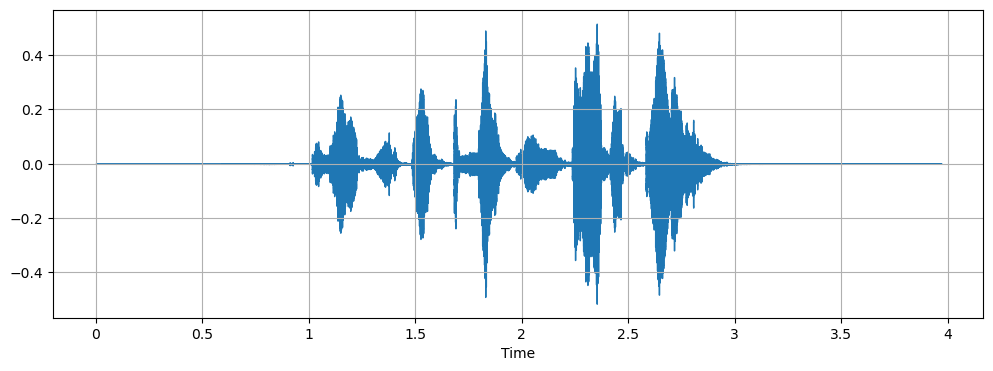

In [38]:
test_audio = load_audio(dataframe.FilePath[3])
plot_audio(test_audio)



# 3. Feature Extraction

### 3.1 Mel-Frequency Cepstral Coefficients (MFCCs)

In [39]:
def extract_mfcc(audio_path:str, sr:float=48000, n_mfcc:int=40,show_plot:bool=False):
    audio = load_audio(audio_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if show_plot:
        librosa.display.specshow(mfcc, x_axis='time')
        plt.ylabel('MFCC')
        plt.colorbar()  
    return np.mean(mfcc.T, axis=0) 

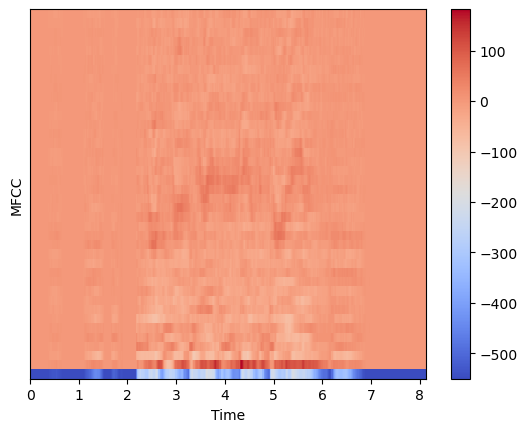

In [40]:
mfcc = extract_mfcc(dataframe.FilePath[2],show_plot=True)


In [41]:
mfcc.shape

(40,)

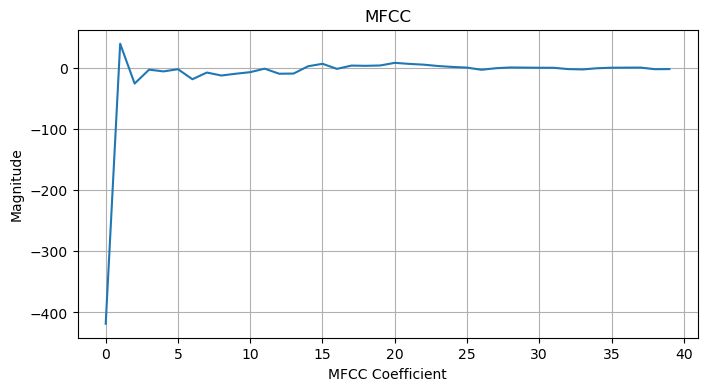

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(mfcc)
plt.title("MFCC")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

### 3.2 Log-Mel Spectrogram

In [43]:
def extract_logmel(audio_path:str, sr:float=48000, n_mels:int=128,show_plot:bool=False):
    audio= load_audio(audio_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel_spectrogram)
    if show_plot:
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, y_axis='mel', sr=sampling_rate, x_axis='time');
        print(logmel.shape)
        plt.title('Mel Spectrogram ')
        plt.colorbar(format='%+2.0f dB')

    return logmel.mean(axis=1)  # Mean across time frames


(128, 351)
(128, 304)


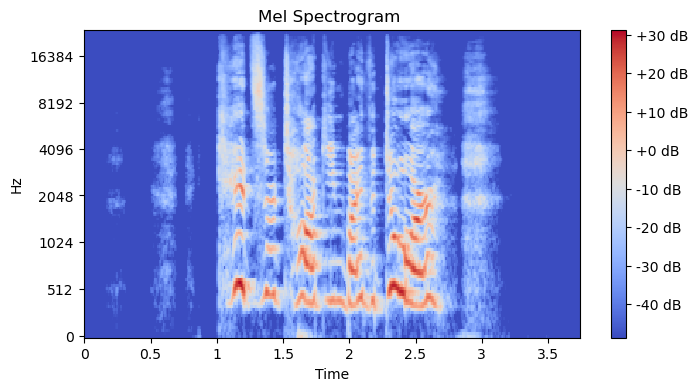

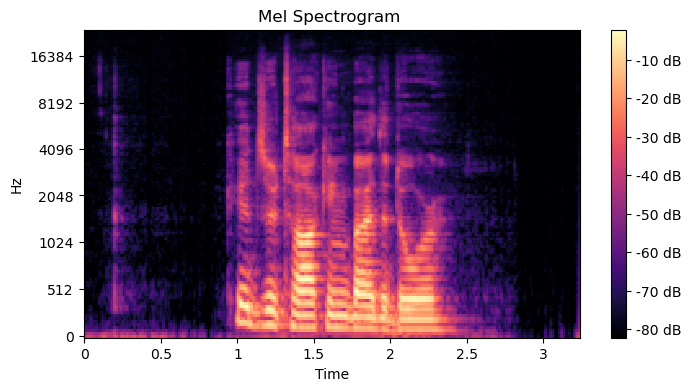

In [44]:
logmel = extract_logmel(dataframe.FilePath[2],show_plot=True)
logmel3 = extract_logmel(dataframe.FilePath[300],show_plot=True)

In [45]:
logmel.shape

(128,)

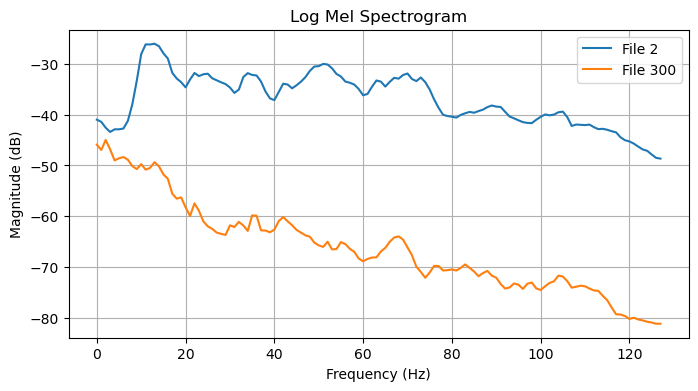

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(logmel, label="File 2")
plt.plot(logmel3, label="File 300")
plt.title("Log Mel Spectrogram")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.show()

### 3.3 Prosodic Features (Pitch, Intensity, Duration)

In [47]:
def extract_prosodic(audio_path:str, sr:float=48000) -> list:
    audio = load_audio(audio_path)
    # Pitch (F0)
    pitches = librosa.yin(audio, fmin=50, fmax=260)
    pitch_mean = pitches.mean()

    # Intensity (Energy)
    energy = np.sqrt(np.mean(audio**2))

    # Duration (Voiced regions)
    voiced_frames = librosa.effects.split(audio, top_db=35)
    duration = sum((v[1] - v[0]) for v in voiced_frames) / sr
    return [pitch_mean, energy, duration]


In [48]:
prosodic_features = extract_prosodic(dataframe.FilePath[2])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 169.65 Hz
Energy: 0.08
Duration: 1.87 seconds


In [49]:
prosodic_features = extract_prosodic(dataframe.FilePath[300])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 146.59 Hz
Energy: 0.00
Duration: 1.56 seconds


### 3.4 Features combination

In [50]:
def extract_features_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    data = []
    for file_path in dataset.FilePath:
            if file_path.endswith(".wav"):
                try:
                    mfcc = extract_mfcc(file_path)
                    logmel = extract_logmel(file_path)
                    prosodic = extract_prosodic(file_path)
                    # Combine features
                    features = np.hstack([mfcc, logmel, prosodic])
                    data.append(features)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    data.append(None)
                    continue
    dataset["Features"] = data    
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS.pkl"
    dataset.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")


In [51]:
output_pickle_folder = "data/pickle/"
extract_features_from_dataset(dataframe, output_pickle_folder)

Features extracted and saved to data/pickle//RAVDESS.pkl


# 4. Feature space visualization

### 4.1 Normalization

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print(f"Original shape: {dataframe.Features.shape}")
scaler = MinMaxScaler()

dataframe.Features =  scaler.fit_transform(np.array(dataframe.Features.tolist())).tolist()

print(f"Normalized shape: {dataframe.Features.shape}")


Original shape: (1440,)
Normalized shape: (1440,)


### 4.2 k-means Clustring

In [75]:
dataframe.head()

,FilePath,Emotion,Label,Features
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5,"[0.5741363545789989, 0.3191087111290555, 0.614..."
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6,"[0.5387043446187242, 0.3625650851509361, 0.613..."
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6,"[0.8423272108545516, 0.21452064161799334, 0.35..."
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5,"[0.7465423799234325, 0.30809608759386187, 0.58..."
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7,"[0.41260364804956395, 0.4724051495382131, 0.70..."


### 4.3 Visualize the Cluster

Method 2 : 
First compute pca and then cluster

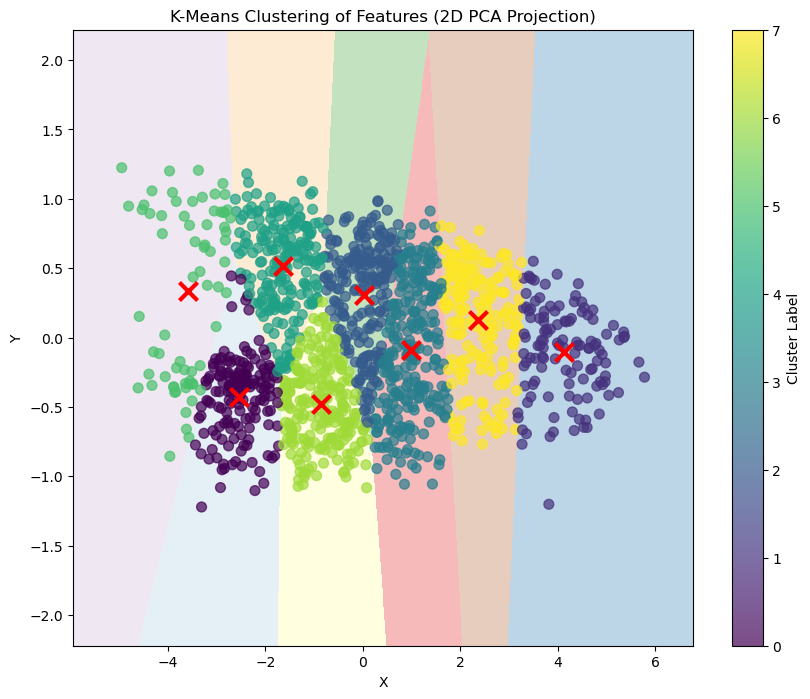

In [191]:
normalized_features = dataframe.Features.tolist()
n_clusters = 8  

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

dataframe["PCA"] = reduced_features.tolist()

kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=1000,init='k-means++')
kmeans.fit(reduced_features)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01 # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Fit k-means to the normalized features
cluster_labels = kmeans.fit_predict(reduced_features)

dataframe["Cluster"] = cluster_labels

plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("K-Means Clustering of Features (2D PCA Projection)")
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="r",
    zorder=10,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### 4.4 Analize the Cluster

#### 4.4.1 Compute the most frequent emotion in each cluster

In [192]:
cluster_to_emotion = dataframe.groupby('Cluster')['Emotion'].agg(lambda x: x.value_counts().idxmax())

dataframe["PredictedEmotion"] = dataframe.Cluster.map(cluster_to_emotion)


In [193]:
cluster_to_emotion

Cluster
0         calm
1        angry
2    surprised
3    surprised
4         calm
5         calm
6      disgust
7        happy
Name: Emotion, dtype: object

In [187]:
dataframe.head()

,FilePath,Emotion,Label,Features,PCA,Cluster,PredictedEmotion
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5,"[0.5741363545789989, 0.3191087111290555, 0.614...","[1.134235620563467, 0.40942536675918845]",0,surprised
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6,"[0.5387043446187242, 0.3625650851509361, 0.613...","[0.7756473248819399, 0.4698484074594598]",0,surprised
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6,"[0.8423272108545516, 0.21452064161799334, 0.35...","[4.102897834973788, -0.01659525093821211]",2,angry
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5,"[0.7465423799234325, 0.30809608759386187, 0.58...","[3.0045520762154063, 0.09858140938461497]",4,happy
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7,"[0.41260364804956395, 0.4724051495382131, 0.70...","[-0.6673020687249677, 0.19552969344648213]",5,surprised


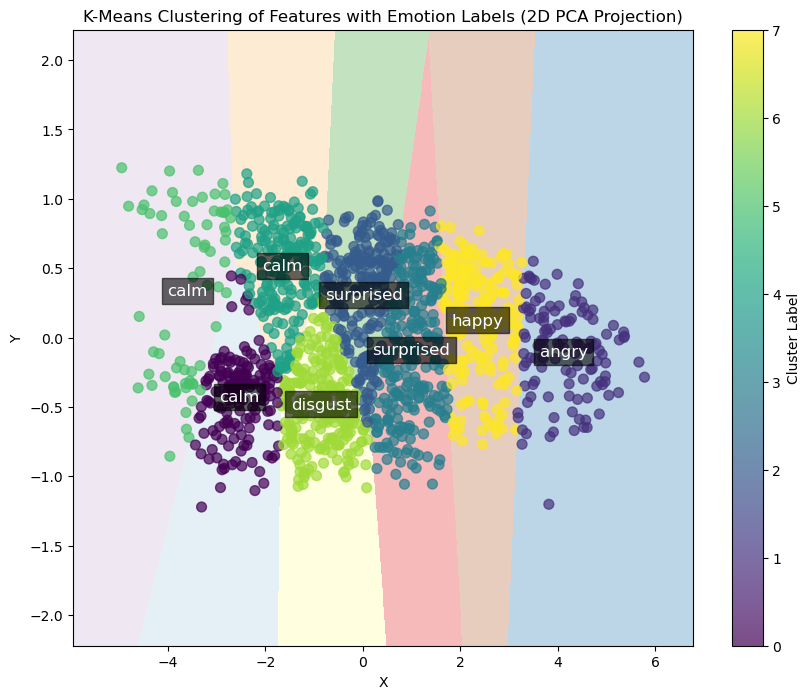

In [195]:
plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7,)
plt.colorbar(scatter, label="Cluster Label")
# Add cluster names
cluster_names = list(cluster_to_emotion.values)  
for i, name in enumerate(cluster_names):
    plt.text(
        centroids[i, 0],  # X coordinate of the centroid
        centroids[i, 1],  # Y coordinate of the centroid
        name,  # The name of the cluster
        fontsize=12,
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        color='white',
        bbox=dict(facecolor='black', alpha=0.6)  # Background box for better visibility
    )
plt.title("K-Means Clustering of Features with Emotion Labels (2D PCA Projection)")

plt.xlabel("X")

plt.ylabel("Y")
plt.show()

# 5. Load Dataset from Pickle file

In [58]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


pickle_file = "data/pickle/RAVDESS.pkl"

### 5.1 Custom Dataset 

#### 5.1.1 Dataset class

In [59]:
class AudioEmotionDataset(Dataset):
    def __init__(self,pick_file:str,transform=None):
        self.data = pd.read_pickle(pick_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        features = self.data.Features[index]
        label = self.data.Label[index]

        if self.transform:
            features = self.transform(features)
        
        return features, label

#### 5.1.2 Normalization & transform function

In [60]:
def normalization(tensor:torch.Tensor)->torch.Tensor:
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

def to_tensor(array:np.ndarray)->torch.Tensor:
    return torch.from_numpy(array).float()

transforms = transforms.Compose(
    [
    to_tensor,
    normalization
    ]
)

dataset = AudioEmotionDataset(pickle_file, transform=transforms)

### 5.2 Split data to Train, Validation, Test 

In [61]:
train_size = int(0.7*dataset.__len__())
val_size = int(0.2*dataset.__len__())
test_size = dataset.__len__() - train_size - val_size

train_data, test_data,val_data  = random_split(dataset, [train_size, test_size, val_size])
len(train_data), len(test_data), len(val_data)



(1007, 145, 288)

### 5.3 DataLoader

In [62]:
batch_size = 34

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [63]:
example_batch_feature, example_batch_label = next(iter(train_loader))

print(f"Batch inputs shape: {example_batch_feature.shape}")
print(f"Batch label shape: {example_batch_label.shape}")

Batch inputs shape: torch.Size([34, 171])
Batch label shape: torch.Size([34])
